<a href="https://colab.research.google.com/github/hasan-sh/advanced-nlp/blob/main/Firstmodel_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer

from sklearn.metrics import *
import matplotlib.pyplot as plt
import seaborn as sns


In [34]:
!git clone https://github.com/hasan-sh/advanced-nlp.git

fatal: destination path 'advanced-nlp' already exists and is not an empty directory.


In [35]:
!pwd

/content


In [36]:
train_file = '/content/advanced-nlp/data/en_ewt-up-train.conllu'
test_file = '/content/advanced-nlp/data/en_ewt-up-test.conllu'

In [37]:
def read_data(file_path, save_to_csv=False):
    """
    This function reads a CoNLL-U format file and converts it into a pandas DataFrame.
    Each row in the DataFrame corresponds to a token in the file, and columns
    correspond to different features of the token, such as the token itself, its lemma, 
    part-of-speech tag, and syntactic dependency information.
    
    Parameters:
    file_path (str): The path to the input CoNLL-U format file.
    save_to_csv (bool): A boolean flag indicating whether to save the resulting DataFrame 
                        to a CSV file. Default is False.
                        
    Returns:
    df (pandas.DataFrame): A pandas DataFrame containing the token-level information from
                           the input file.
    """
    
    # Open and read the input file
    with open(file_path, 'r', encoding='utf-8') as f:
        train_data = f.read()
    
    # Split the file into individual documents, each separated by a blank line
    data = []
    for doc_i, doc in enumerate(train_data.split('\n\n')):
        doc = doc.split('\n')
        sentences = ''
        for line in doc:
            # Skip lines starting with '#' (comment lines)
            if line and line[0] != '#':
                line = line.split('\t')
                line.insert(0, str(doc_i))
                sentences += '\t'.join(line) + '\n'
        data.append(sentences)
    
    # Create a pandas DataFrame from the token-level data
    train_df = pd.DataFrame([x.split('\t') for sent in data for x in sent.split('\n') if x])
    
    # Rename the columns of the DataFrame
    train_df = train_df.rename(columns={
        0:'sent_id', 
        1:'token_id', 
        2:'token', 
        3:'lemma', 
        4:'POS', 
        5:'uni_POS',
        6:'morph_type', 
        7:'distance_head', 
        8:'dep_label', 
        9:'dep_rel', 
        10:'space', 
        11:'probbank'
    })
    
    # Convert the DataFrame from wide to long format
    df = train_df.melt(
        id_vars=[i for i in train_df.columns[:12]], 
        var_name="notneeded", 
        value_name="target"
    )
    
    # Drop the 'notneeded' column and any rows that contain missing values
    #df["sent_id"]=df['sent_id'].str.cat((df['notneeded'].astype(int)-12).astype(str) , sep="_" )
    df["repetion_id"]=df["notneeded"]-12
    df.drop(['notneeded'], axis=1, inplace=True)
    df = df[df['target'].notna()]
    
    # Optionally save the resulting DataFrame to a CSV file
    if save_to_csv:
        df.to_csv('/content/advanced-nlp/data/test.tsv', sep='\t', index=False)
    
    # Return the resulting DataFrame

    return df

In [38]:
train = read_data(train_file,save_to_csv=True)
test = read_data(test_file, save_to_csv=True)

In [39]:
def make_binary_label(df):
  df = df.assign(label=[0 if target=="_" or target=="V" else 1 for target in df['target']])
  df= df.drop('target', axis=1)
  return df

#clean column
def columns_cleaning(df): #political choices inside
  """This function perform a preprocessing steps that consists of:
  - in removing rows with missinvg value for distance head feature
  - cast numerical features to int 
  - drop token_id (I belive is useless)
  

  """
  df=df[df["distance_head"]!="_"]#like this
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
  
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE

  df= df.drop('token_id', axis=1) #or this
  df=df[['sent_id', 'repetion_id','token', 'lemma', 'POS', 'uni_POS', 'morph_type',
        'distance_head', 'dep_label', 'dep_rel', 'space', 'probbank' ,'label']]

  return df


def make_NER(df):
  return df


"""cols_to_encode=[ 'token', 'lemma', 'POS', 'uni_POS',
       'morph_type', 'dep_label', 'dep_rel', 'space',
       'probbank']"""

cols_to_encode=[ 'POS', 'uni_POS',
       'morph_type', 'dep_label', 'dep_rel', 'space',
       'probbank']

def create_encoding(df,cols_to_encode):
  """This function creates a label encoding (just assign number to every value) for all columns in the list cols_to_encode """
  # create a LabelEncoder objec
  le = LabelEncoder()
  # iterate over the columns to encode
  for col in cols_to_encode:
      df[col] = le.fit_transform(df[col])
      
  return df




##BASELINE WITH ONLY TOKEN

In [40]:
def prepare_token_data(tokens_train,tokens_test):
  vectorizer = CountVectorizer()
  X_train = vectorizer.fit_transform(tokens_train['token'])
  X_test = vectorizer.transform(tokens_test['token'])
  y_train=tokens_train['label']
  y_test=tokens_test['label']

  return X_train,X_test,y_train,y_test


In [41]:
def logistic_reg(X_train,X_test,y_train,y_test):
  #instantiate the model
  log_regression = LogisticRegression(penalty='l2')

  #fit the model using the training data
  log_regression.fit(X_train,y_train)

  #use model to make predictions on test data
  y_pred = log_regression.predict(X_test)
  return y_pred

In [46]:
def confusion_mtrx(y_test,y_pred):

  cm = confusion_matrix(y_test, y_pred)
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, fmt='g', ax=ax,cmap='Blues');  #annot=True to annotate cells, ftm='g' to disable scientific notation
  sns.color_palette("tab10")

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix'); 
  ax.xaxis.set_ticklabels(['non_arg', 'arg']); ax.yaxis.set_ticklabels(['non_arg', 'arg']);
  return 0

In [43]:
tokens_train=train[["token","target"]]
tokens_test=test[["token","target"]]
tokens_train=make_binary_label(tokens_train)
tokens_test=make_binary_label(tokens_test)
X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
y_pred=logistic_reg(X_train,X_test,y_train,y_test)
f1 = f1_score(y_test,y_pred)
print(f"{f1=}")


f1=0.02061855670103093


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0

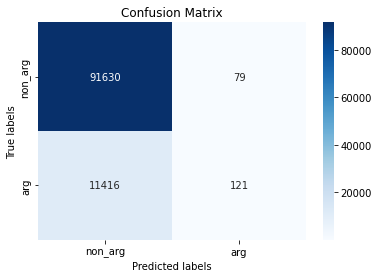

In [47]:
confusion_mtrx(y_test,y_pred)

LETS DOWN SAMPLE 

first the first N rows are considered

In [66]:
sample_size = [x for x in range(10000,100000,10000)] + [x for x in range(100000,train.shape[0],100000)] + [train.shape[0]]
sample_size

[10000,
 20000,
 30000,
 40000,
 50000,
 60000,
 70000,
 80000,
 90000,
 100000,
 200000,
 300000,
 400000,
 500000,
 600000,
 700000,
 800000,
 900000,
 1000000,
 1035928]

In [62]:
f1_scores=[]
true_predicts=[]
for x in sample_size:
  print(f"{x=}")
  tokens_train=train[["token","target"]][:x]
  tokens_test=test[["token","target"]]
  tokens_train=make_binary_label(tokens_train)
  tokens_test=make_binary_label(tokens_test)
  X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
  y_pred=logistic_reg(X_train,X_test,y_train,y_test)
  predicted_true=y_pred.sum()
  true_predicts.append(predicted_true)
  print(f"{predicted_true=}")
  f1 = f1_score(y_test,y_pred)
  f1_scores.append(f1)
  print(f"{f1=}")
  print("=====\n")

x=10000
predicted_true=65
f1=0.004654369936217893
=====

x=20000
predicted_true=84
f1=0.005507271319163584
=====

x=30000
predicted_true=130
f1=0.007371217965200995
=====

x=40000
predicted_true=286
f1=0.019622769178719444
=====

x=50000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=659
f1=0.03820924893407675
=====

x=60000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=791
f1=0.04558728098637249
=====

x=70000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=725
f1=0.04730060349045832
=====

x=80000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=795
f1=0.05108660395718457
=====

x=90000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=802
f1=0.0513817975524759
=====

x=100000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=817
f1=0.053100210458151206
=====

x=200000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=733
f1=0.048573757131214354
=====

x=300000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=308
f1=0.029886027859856484
=====

x=400000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=261
f1=0.02542803865061875
=====

x=500000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=246
f1=0.024102520580497326
=====

x=600000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=266
f1=0.025756163687198172
=====

x=700000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=246
f1=0.023932784520071287
=====

x=800000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=218
f1=0.021437686091025098
=====

x=900000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=209
f1=0.020943299846756344
=====

x=1000000


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=195
f1=0.019434026593931134
=====

x=1035928
predicted_true=200
f1=0.02061855670103093
=====



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [67]:
sample_size,f1_scores,true_predicts

([10000,
  20000,
  30000,
  40000,
  50000,
  60000,
  70000,
  80000,
  90000,
  100000,
  200000,
  300000,
  400000,
  500000,
  600000,
  700000,
  800000,
  900000,
  1000000,
  1035928],
 [0.004654369936217893,
  0.005507271319163584,
  0.007371217965200995,
  0.019622769178719444,
  0.03820924893407675,
  0.04558728098637249,
  0.04730060349045832,
  0.05108660395718457,
  0.0513817975524759,
  0.053100210458151206,
  0.048573757131214354,
  0.029886027859856484,
  0.02542803865061875,
  0.024102520580497326,
  0.025756163687198172,
  0.023932784520071287,
  0.021437686091025098,
  0.020943299846756344,
  0.019434026593931134,
  0.02061855670103093],
 [65,
  84,
  130,
  286,
  659,
  791,
  725,
  795,
  802,
  817,
  733,
  308,
  261,
  246,
  266,
  246,
  218,
  209,
  195,
  200])

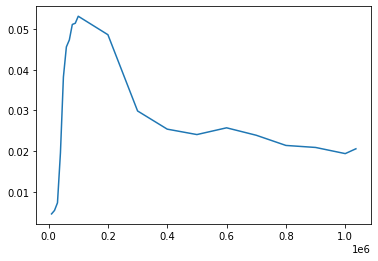

In [69]:
plt.plot(sample_size,f1_scores)

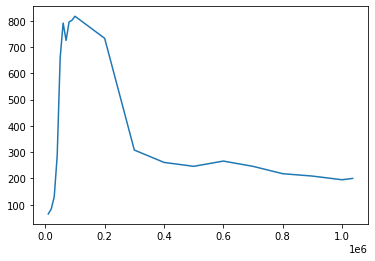

In [70]:
plt.plot(sample_size,true_predicts)

Now lets down sample the negative class same proportion

In [ ]:
down_sample_size =  [x for x in range(700000,900000,10000)] 

down_sample_size

In [74]:
f1_scores=[]
true_predicts=[]
n_samples=[]
for x in down_sample_size:
  print(f"{x=}")
  tokens_train=train[["token","target"]]
  tokens_test=test[["token","target"]]
  tokens_train=make_binary_label(tokens_train)
  tokens_test=make_binary_label(tokens_test)

  tokens_train = tokens_train.drop(tokens_train[tokens_train['label']==0].sample(n=x).index)
  n_samples.append(tokens_train.shape[0])
  print(tokens_train.shape[0])
  X_train,X_test,y_train,y_test=prepare_token_data(tokens_train,tokens_test)
  y_pred=logistic_reg(X_train,X_test,y_train,y_test)
  
  predicted_true=y_pred.sum()
  true_predicts.append(predicted_true)
  print(f"{predicted_true=}")

  f1 = f1_score(y_test,y_pred)
  f1_scores.append(f1)
  print(f"{f1=}")
  print("=====\n")

x=700000
335928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=9448
f1=0.24627114605670716
=====

x=710000
325928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=9641
f1=0.2477098876192275
=====

x=720000
315928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=11072
f1=0.26157724799858467
=====

x=730000
305928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=13126
f1=0.27993350362891783
=====

x=740000
295928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=13807
f1=0.28172348484848486
=====

x=750000
285928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=15456
f1=0.28918608528136924
=====

x=760000
275928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=16858
f1=0.29589716499383695
=====

x=770000
265928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=18732
f1=0.2982589447950048
=====

x=780000
255928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=20810
f1=0.30834389587906147
=====

x=790000
245928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=22520
f1=0.3099509645594151
=====

x=800000
235928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=23213
f1=0.31027338129496407
=====

x=810000
225928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=25718
f1=0.31126023352570126
=====

x=820000
215928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=27661
f1=0.31154650747487117
=====

x=830000
205928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=30406
f1=0.3147128245476003
=====

x=840000
195928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=31901
f1=0.31175468483816016
=====

x=850000
185928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=34073
f1=0.3098881824161368
=====

x=860000
175928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=36095
f1=0.3073563990594558
=====

x=870000
165928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=63478
f1=0.2728520962474172
=====

x=880000
155928


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


predicted_true=66998
f1=0.2683898898580251
=====

x=890000
145928
predicted_true=68897
f1=0.266156103140463
=====



/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


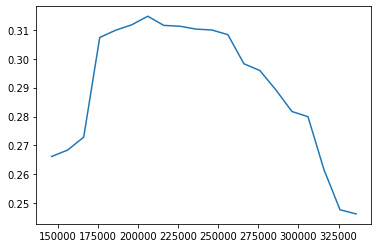

In [75]:
plt.plot(n_samples,f1_scores)

##WITH BASIC FEATURES

In [ ]:

##WRAPPER FUNCTION
def process_dataset(df):
  
  df=make_binary_label(df)

  df=columns_cleaning(df)

  df=make_NER(df)

  cols_to_encode=[ 'token', 'lemma', 'POS', 'uni_POS', 'morph_type', 'dep_label', 'dep_rel', 'space', 'probbank']
  df=create_encoding(df,cols_to_encode)

  return df

In [ ]:
df_train=process_dataset(train)
df_test=process_dataset(test)


In [ ]:
X_train=df_train
y_train=X_train.pop('label')


X_test=df_test
y_test=X_test.pop('label')


THE MODEL


In [ ]:
#instantiate the model
log_regression = LogisticRegression(penalty='l2')

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = log_regression.predict(X_test)

f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
print(f"{f1=}")
print(f"{prec=}")


In [ ]:
y_pred.sum()

SOoo the issue is that keeps crashing if we put countvector or onehotvector along with other feature

##ONLY CATHEGORICAL FEATURES

In [ ]:
train.columns

Index(['sent_id', 'token_id', 'token', 'lemma', 'POS', 'uni_POS', 'morph_type',
       'distance_head', 'dep_label', 'dep_rel', 'space', 'probbank', 'target',
       'repetion_id'],
      dtype='object')

In [ ]:
col=['sent_id', 'token_id', 'POS', 'uni_POS', 'morph_type',
       'distance_head', 'dep_label', 'dep_rel', 'space', 'probbank', 'target',
       'repetion_id']

In [ ]:
ttrain=train[col]
ttest=test[col]

In [ ]:
def columns_cleaning(df): #political choices inside
  df=df[df["distance_head"]!="_"]#like this
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
  
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE

  df= df.drop('token_id', axis=1) #or this
  df=df[['sent_id', 'repetion_id','POS', 'uni_POS', 'morph_type',
        'distance_head', 'dep_label', 'dep_rel', 'space', 'probbank' ,'label']]

  return df

In [ ]:


def create_encoding(df,cols_to_encode):
  # create a LabelEncoder objec
  le = LabelEncoder()

  # iterate over the columns to encode
  for col in cols_to_encode:
      df[col] = le.fit_transform(df[col])
  return df


In [ ]:
ttrain=make_binary_label(ttrain)
ttest=make_binary_label(ttest)

ttrain=columns_cleaning(ttrain)
ttest=columns_cleaning(ttest)

col=[ 'POS', 'uni_POS',
       'morph_type', 'dep_label', 'dep_rel', 'space',
       'probbank']

ttrain=create_encoding(ttrain,col)
ttest=create_encoding(ttest,col)

<ipython-input-29-2295377dbcc6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["distance_head"]=df["distance_head"].astype(int) #WARNING IS FROM HERE
<ipython-input-29-2295377dbcc6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sent_id"]=df["sent_id"].astype(int) #WARNING IS FROM HERE


,sent_id,repetion_id,POS,uni_POS,morph_type,distance_head,dep_label,dep_rel,space,probbank,label
0,0,0,11,24,74,0,46,0,30,1,0
1,0,0,12,15,100,1,44,3130,30,1,0
2,0,0,11,24,74,1,25,2995,31,1,0
3,0,0,12,6,100,1,44,3130,31,1,0
4,0,0,0,17,41,6,4,9101,31,1,0
...,...,...,...,...,...,...,...,...,...,...,...
7077906,7506,34,15,41,90,123,2,756,31,1238,0
7077907,7506,34,4,9,100,134,9,1097,31,1,0
7077908,7506,34,10,29,36,134,35,1098,31,1,1
7077909,7506,34,15,42,63,4,14,7504,31,1300,0


In [ ]:
ttrain['POS'].corr(ttrain['label'])

0.01904687298490898

In [ ]:
X_train=ttrain
y_train=X_train.pop('label')


X_test=ttest
y_test=X_test.pop('label')


In [ ]:
ttrain

,sent_id,repetion_id,POS,uni_POS,morph_type,distance_head,dep_label,dep_rel,space,probbank
0,0,0,11,24,74,0,46,0,30,1
1,0,0,12,15,100,1,44,3130,30,1
2,0,0,11,24,74,1,25,2995,31,1
3,0,0,12,6,100,1,44,3130,31,1
4,0,0,0,17,41,6,4,9101,31,1
...,...,...,...,...,...,...,...,...,...,...
7077906,7506,34,15,41,90,123,2,756,31,1238
7077907,7506,34,4,9,100,134,9,1097,31,1
7077908,7506,34,10,29,36,134,35,1098,31,1
7077909,7506,34,15,42,63,4,14,7504,31,1300


THE MODEL


In [ ]:
#instantiate the model
log_regression = LogisticRegression(penalty='l2')

#fit the model using the training data
log_regression.fit(X_train,y_train)

#use model to make predictions on test data
y_pred = log_regression.predict(X_test)

f1 = f1_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)
print(f"{f1=}")
print(f"{prec=}")


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


f1=0.0
prec=0.0


In [ ]:
y_pred.sum()

3

##COLUMNT TRANSFORMER ATTEMPT (ignore)

In [ ]:
ct = ColumnTransformer([("token_vec", OneHotEncoder(), ["token"])], remainder="passthrough",sparse_threshold=0)

In [ ]:
dataset = ct.fit_transform(ttrain)

In [ ]:
dataset.shape

(103246, 4880)

In [ ]:
dataset.shape

(103246, 4881)